# Basic ML with TF

A few simple implementations in TF.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from functools import partial

# k-means

In [2]:
def cluster_distances(x, clusters):
    """Get the distance from x for each cluster.
    
    Args:
        x: Tensor of shape [B x F].
        clusters: Tensor of shape [K x F].
    
    Returns:
        Tensor of shape [B x K], distance of each x to K-th cluster.
    """
    return tf.sqrt(tf.reduce_sum(tf.square(x[:, None] - clusters[None, :]), axis=-1))

def cluster_probs(x, clusters):
    """Compute probabilities of x belonging to clusters.

    Args:
        x: Tensor of shape [B x F].
        clusters: Tensor of shape [K x F].

    Returns:
        Tensor of shape [B x K], probability of each x in K-th cluster.
    """
    distances = cluster_distances(x, clusters)
    return 1. - tf.nn.softmax(distances ** 2, axis=-1)

def initial_clusters(x, k, probs=None):
    """Choose initial clusters via kmeans++.

    Args:    
        x: Tensor of shape [B x F]. B is the dataset size, F is the 
            feature size.
        k: Tensor of shape [], defining the number of desired clusters.
        probs: (optional) Tensor of [N], initial probabilities of cluster 
            assignments, defaults to uniform.

    Returns:
        Tensor of shape [K x F] clusters.
    """
    size = tf.shape(x)[0]
    if probs is None:
        probs = tf.ones(size, tf.float32) / tf.cast(size, tf.float32)
    mask = tf.ones(size, tf.float32)
    clusters = tf.zeros([k, tf.shape(x)[-1]], tf.float32)
    for i in tf.range(k, dtype=tf.int32):
        index = tfp.distributions.Categorical(probs=probs).sample()
        mask -= tf.one_hot(index, size, dtype=tf.float32)
        clusters = tf.tensor_scatter_nd_update(clusters, [[i]], x[None, index])
        probs = tf.math.reduce_min(cluster_probs(x, clusters[:i+1]), axis=-1)
        probs *= mask
    return clusters

def wcss(x, clusters):
    """Computes the within-cluster sum of squares.

    Args:
        x: Tensor of shape [B x F].
        clusters: Tensor of shape [K x F].

    Returns:
        Scalar value.
    """
    distances = tf.reduce_min(cluster_distances(x, clusters), axis=-1)
    return tf.reduce_sum(tf.square(distances))

def kmeans(x, k, probs=None):
    """Cluster points into clusters via k-means++.

    Example:
        ```python
        x = tf.constant([[-0.25], [-0.1], [0.1], [0.25]], tf.float32)
        k = tf.constant(2, tf.int64)
        dist_fn, clusters = kmeans(x, k)
        predictions = tfp.distributions.Categorical(probs=dist_fn(x)).mode()
        ```

    Args:
        x: Tensor of shape [B x F]. B is the dataset size, F is the 
            feature size.
        k: Tensor of shape [], defining the number of desired clusters.
        probs: (optional) Tensor of [N], initial probabilities of cluster 
            assignments, defaults to uniform.

    Returns: 
        Tuple:
            - function that maps samples to probabilities of belonging to the k 
                clusters.
            - cluster tensor.
    """
    clusters = initial_clusters(x, k, probs=probs)
    assignments = tfp.distributions.Categorical(
        probs=cluster_probs(x, clusters)).mode()
    prev_assignments = tf.fill(tf.shape(assignments), 
                               tf.constant(-1, assignments.dtype))

    while tf.reduce_all(prev_assignments != assignments):
        prev_assignments = assignments
        clusters = tf.zeros_like(clusters)
        for i in tf.range(k, dtype=tf.int32):
            x_cluster = tf.boolean_mask(x, assignments == i)
            new_cluster = tf.reduce_mean(x_cluster, axis=0)[None]
            clusters = tf.tensor_scatter_nd_update(clusters, [[i]], new_cluster)
        assignments = tfp.distributions.Categorical(
            probs=cluster_probs(x, clusters)).mode()

    def dist_fn(x_test):
        return cluster_probs(x_test, clusters)
    return dist_fn, clusters

WCSS 127.791306


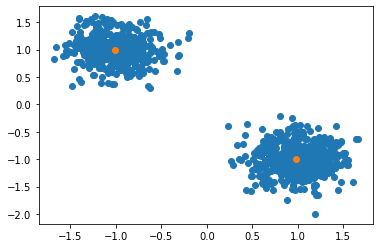

In [3]:
dist = tfp.distributions.Mixture(
    tfp.distributions.Categorical(probs=[.5, .5]),
    [
        tfp.distributions.MultivariateNormalDiag(loc=[-1., 1.], scale_diag=[.25, .25]),
        tfp.distributions.MultivariateNormalDiag(loc=[1., -1.], scale_diag=[.25, .25])
    ],
)
x = dist.sample(1000)
k = tf.constant(2, tf.int64)
dist_fn, clusters = kmeans(x, k)
plt.scatter(x[:, 0], x[:, 1])
plt.scatter(clusters[:, 0], clusters[:, 1])
print("WCSS", wcss(x, clusters).numpy())

# Naive Bayes

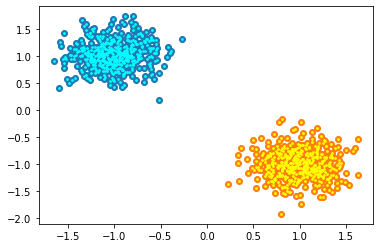

In [4]:
def naive_bayes(locs, scale_diags, probs):
    """Creates a naive bayes classifer from the given loc, scale and probs.
    
    Args:
        loc: Tensor of shape [... x C x F]. C is classes, F is features.
        scale_diags: Tensor of shape [... x C x F]. C is classes, F is features.
        prob: Tensor of shape [... x C]. C is classes.

    Returns:
        function that maps samples to probabilities.
    """
    x_dists = [tfp.distributions.MultivariateNormalDiag(loc=loc, 
                                                        scale_diag=scale_diag) 
               for loc, scale_diag in zip(locs, scale_diags)]
    cat_dist = tfp.distributions.Categorical(probs=probs)
    def dist_fn(x):
        probs = tf.stack([x_dist.prob(x) for x_dist in x_dists], axis=-1)
        probs *= cat_dist.probs[None, :]
        probs /= tf.reduce_sum(probs) # Normalization constant.
        return probs
    return dist_fn

dist = tfp.distributions.Mixture(
    tfp.distributions.Categorical(probs=[0.5, 0.5]),
    [
        tfp.distributions.MultivariateNormalDiag(loc=[-1., 1.], scale_diag=[.25, .25]),
        tfp.distributions.MultivariateNormalDiag(loc=[1., -1.], scale_diag=[.25, .25])
    ],
)
x = dist.sample(1000)
k = tf.constant(2, tf.int64)
dist_fn, _ = kmeans(x, k)
y = tfp.distributions.Categorical(probs=dist_fn(x)).mode()
x0 = x[y == 0]
loc0, var_diag0 = tf.nn.moments(x0, [0])
scale_diag0 = tf.sqrt(var_diag0)
x1 = x[y == 1]
loc1, var_diag1 = tf.nn.moments(x1, [0])
scale_diag1 = tf.sqrt(var_diag1)

dist_fn = naive_bayes([loc0, loc1], [scale_diag0, scale_diag1], [0.5, 0.5])
ys = tfp.distributions.Categorical(probs=dist_fn(x)).mode()

plt.scatter(x0[:, 0], x0[:, 1])
plt.scatter(x1[:, 0], x1[:, 1])

x0s = x[ys == 0]
x1s = x[ys == 1]
plt.scatter(x0s[:, 0], x0s[:, 1], s=3, c="cyan")
plt.scatter(x1s[:, 0], x1s[:, 1], s=3, c="yellow")

# PCA

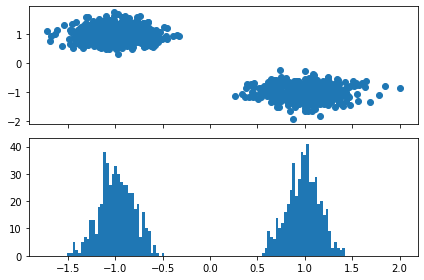

In [5]:
def pca(x, mean=None):
    num_samples = tf.shape(x)[0]
    if mean is None:
        mean = tf.reduce_mean(x, axis=0)
    s, u, v = tf.linalg.svd(x - mean[None, :])
    components = tf.transpose(v)
    explained_variance = (s ** 2) / (tf.cast(num_samples, x.dtype) - 1)

    def transform(x_test, num_components, whiten=False):
        b = tf.transpose(components[:num_components])
        a = x_test - mean[None, :]
        x_test = tf.matmul(a, b)
        if whiten:
            x_test /= tf.sqrt(explained_variance[None, :num_components])
        return x_test

    def inv_transform(x_test, whiten=False):
        num_components = tf.shape(x_test)[-1]
        variance = components[:num_components]
        if whiten:
            variance /= tf.sqrt(explained_variance[:num_components, None])
        return tf.matmul(x_test, variance) + mean
    return transform, inv_transform

dist = tfp.distributions.Mixture(
    tfp.distributions.Categorical(probs=[.5, .5]),
    [
        tfp.distributions.MultivariateNormalDiag(loc=[-1., 1.], scale_diag=[.25, .25]),
        tfp.distributions.MultivariateNormalDiag(loc=[1., -1.], scale_diag=[.25, .25])
    ],
)
x = dist.sample(1000)
pca_transform, pca_inv_transform = pca(x)
x_transformed = pca_transform(x, 1, whiten=True)
f, ax = plt.subplots(nrows=2, sharex=True)
ax[0].scatter(x[:, 0], x[:, 1])
ax[1].hist(tf.squeeze(x_transformed).numpy(), bins=100)
plt.tight_layout()

# SVM (wip)

In [6]:
# TODO(x):

# Decision Tree (wip)

In [7]:
# TODO(x):

# Gaussian and Student's t Process

In [8]:
def gaussian_process(x_train, y_train, y_train_variance, kernel):
    """Creates a function that creates a distribution over test points (0 mean).

    Args:
        x_train: Tensor of shape [B x Fx].
        y_train: Tensor of shape [B x Fy].
        y_train_variance: Variance tensor with shape [B x B] or scalar.
        kernel: Covaraince function that takes ([Bx x F], [By x F]) and 
            returns a tensor with shape [Bx, By].

    Returns:
        A function that takes test points and returns distribution parameters.

    References and resources:
        - Book on GPs (algorithm 2.1): http://www.gaussianprocess.org/gpml/chapters/RW.pdf
        - Lecture from Nando from DM on Gaussians and GPs: https://www.youtube.com/watch?v=4vGiHC35j9s
        - Blog post about visual interpretation: https://distill.pub/2019/visual-exploration-gaussian-processes/
        - Using GPs in the real world: https://distill.pub/2020/bayesian-optimization/
    """
    K = kernel(x_train, x_train)
    I = tf.eye(tf.shape(K)[0])
    L = tf.linalg.cholesky(K + y_train_variance * I)
    L_y = tf.linalg.solve(L, y_train)
    alpha = tf.linalg.solve(L, L_y, adjoint=True)

    def dist_fn(x_test):
        """Creates a distribution over functions of the test points.

        Args:
            x_test: Tensor of shape [B x F].

        Returns:
            Multivariate parameters over [B] test points.
        """
        K_x = kernel(x_train, x_test)
        loc = tf.transpose(K_x) @ alpha
        v = tf.linalg.solve(L, K_x)
        K_xx = kernel(x_test, x_test)
        var = K_xx - tf.transpose(v) @ v
        scale_tril = tf.linalg.cholesky(var)
        loc = tf.transpose(loc)
        return loc, scale_tril
    return dist_fn

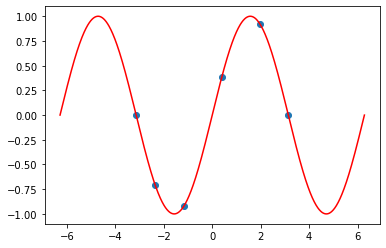

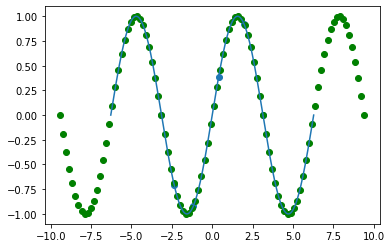

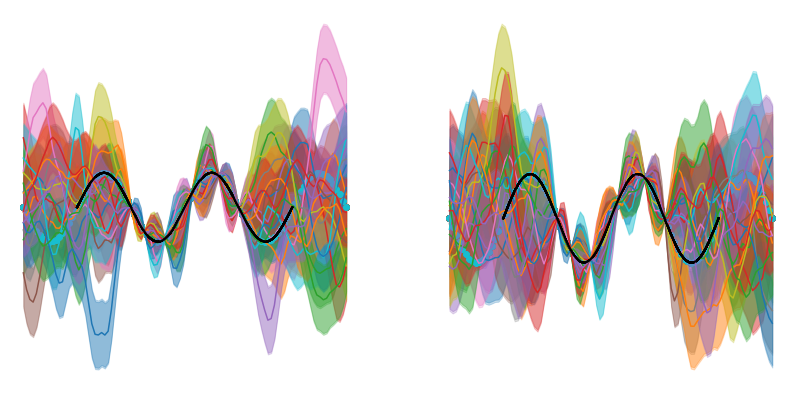

In [9]:
pi = 3.14159265359
x = pi * tf.linspace(-2., 2., 1000)
y = tf.math.sin(x)

x_train = tf.expand_dims(pi * .5 * tf.constant([-2, -1.5, -.75, 0.25, 1.25, 2.]), axis=-1)
y_train = tf.math.sin(x_train)
plt.scatter(x_train, y_train)
plt.plot(x, y, "r")
plt.show()

x_test = tf.expand_dims(pi * .5 * tf.linspace(6., -6, 100), axis=-1)
y_test_gt = tf.math.sin(x_test)
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test_gt, c="g")
plt.plot(x, y)
plt.show()

y_train_variance = 1e-5
gp_fn = gaussian_process(x_train, y_train, y_train_variance, 
                         tfp.math.psd_kernels.MaternFiveHalves().matrix)

loc, scale_tril = gp_fn(x_test)
gp_dists = [
    tfp.distributions.MultivariateStudentTLinearOperator(
        df=50,
        loc=loc,
        scale=tf.linalg.LinearOperatorLowerTriangular(scale_tril)),
    tfp.distributions.MultivariateNormalTriL(
        loc=loc, scale_tril=scale_tril)
]

num_samples = 15
f, ax = plt.subplots(1, 2, figsize=(14, 7))
for i, gp_dist in enumerate(gp_dists):
    y_test_samples = tf.squeeze(gp_dist.sample(num_samples))
    y_test_std = tf.squeeze(gp_dist.stddev())

    for y_test in y_test_samples.numpy():
        ax[i].scatter(x_train, y_train)
        ax[i].scatter(x_test, y_test_gt)

        l, = ax[i].plot(x_test, y_test)
        ax[i].fill_between(tf.squeeze(x_test), y_test + 1. * y_test_std, 
                        y_test - 1. * y_test_std, alpha=.25, color=l.get_color())
        ax[i].fill_between(tf.squeeze(x_test), y_test + .95 * y_test_std, 
                        y_test - .95 * y_test_std, alpha=.33, color=l.get_color())
        ax[i].plot(x, y, color="k", lw=2)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].axis("off")

# Optimization

## Gradient Descent

In [10]:
def update_gradient_descent(grad, param, step_size=1e-3):
    param -= step_size * grad
    return param

def gradient_descent(step_size):
    def update_fn(grads, params):
        params = tf.nest.map_structure(
            partial(update_gradient_descent, step_size=step_size), 
            grads, params)
        return params
    return update_fn

dist = tfp.distributions.Normal(loc=tf.zeros([4]), scale=tf.ones([4]))
grads = (dist.sample(), dist.sample())
params = (dist.sample(), dist.sample())
params = gradient_descent(1e-3)(grads, params)
params

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.79235685,  0.44843155, -0.5283478 ,  0.30661196], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.11056978, -0.18925089,  1.4182732 , -1.2482995 ], dtype=float32)>)

## Newton's method

In [11]:
def update_newtons_method(grad, dgrad, param, step_size=1.):
    n = tf.reduce_prod(tf.shape(param))
    grad = tf.reshape(grad, [n, 1])
    dgrad = tf.reshape(dgrad, [n, n])
    dparam = tf.linalg.solve(dgrad, -grad) # solve for ddf @ -(ddf^-1 @ df) = -df
    dparam = tf.reshape(dparam, tf.shape(param))
    return param + dparam

def newtons_method(step_size=1.):
    def update_fn(grads, dgrads, params):
        params = tf.nest.map_structure(partial(update_newtons_method, step_size=step_size), 
                                       grads, dgrads, params)
        return params
    return update_fn

dist = tfp.distributions.Normal(loc=tf.zeros([4]), scale=tf.ones([4]))
grads = (dist.sample(), dist.sample())
dgrads = (dist.sample(4), dist.sample(4))
params = (dist.sample(), dist.sample())
params = newtons_method()(grads, dgrads, params)
params

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 23.359753, -76.52569 ,  78.66979 , -34.047096], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 1.0140734 ,  0.6710834 , -1.5273664 , -0.34846896], dtype=float32)>)

## Adam

In [12]:
def update_adam(grad, param, m, v, t=0, step_size=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-7):
    """Compute Adam update.

    Reference:
        https://arxiv.org/pdf/1412.6980.pdf
    """
    a = step_size * ((1. - beta2 ** t) ** .5) / (1. - beta1 ** t)
    # Estimate the moving first order moment (basically like the mean).
    m = (m * beta1) + grad * (1. - beta1)
    # Estimate the moving second order moment (basically like the variance).
    v = (v * beta2) + (grad ** 2) * (1 - beta2)
    # Correct for bias from the arbitrary initialization set to 0.
    mt = m / (1 - beta1 ** t)
    vt = v / (1 - beta2 ** t)
    param -= ((mt * a) / ((vt ** .5) + epsilon))
    return param, m, v

def adam(step_size, beta1, beta2, epsilon):
    def update_fn(grads, params, ms, vs, t):
        t += 1
        x = tf.nest.map_structure(
            partial(update_adam, t=t, step_size=step_size, beta1=beta1, 
                    beta2=beta2, epsilon=epsilon), 
            grads, params, ms, vs)
        params, ms, vs = zip(*x)
        return params, ms, vs, t
    return update_fn

dist = tfp.distributions.Normal(loc=tf.zeros([4]), scale=tf.ones([4]))
grads = (dist.sample(), dist.sample())
params = (dist.sample(), dist.sample())
ms = (tf.zeros_like(grads[0]), tf.zeros_like(grads[1]))
vs = (tf.zeros_like(grads[0]), tf.zeros_like(grads[1]))
t = tf.ones([])
params, ms, vs, t = adam(1e-3, 0.9, 0.999, 1e-7)(grads, params, ms, vs, t)
params

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.46893054, -0.31553882,  0.2072074 ,  1.2046032 ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.24966978,  1.4796425 , -0.23016848,  0.03487961], dtype=float32)>)

# Linear Regression

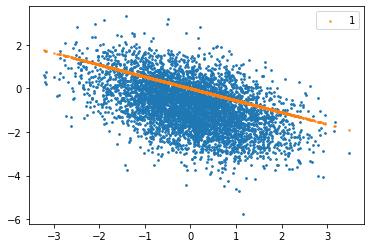

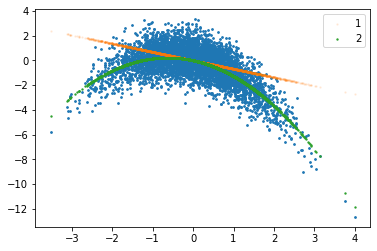

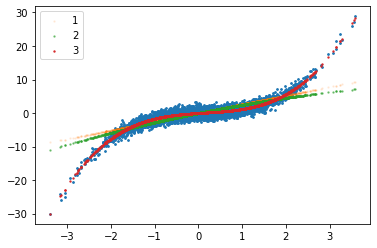

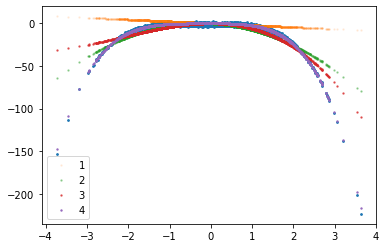

In [13]:
def polynomial_features(x, order):
    return tf.concat([x ** p for p in range(1, order + 1)], axis=-1)

def random_polynomial(size, order, eps=1e-3):
    x = tfp.distributions.Normal(loc=[0.], scale=[1.]).sample(size)
    eps = tfp.distributions.Normal(loc=[0.], scale=[eps]).sample(size)
    y = sum([tfp.distributions.Normal(loc=0., scale=1.).sample() * (x ** p) 
             for p in range(order + 1)])
    return x, y + eps

max_order = 4
for order in range(1, max_order + 1):
    x, y = random_polynomial(5000, order, 1.)
    plt.scatter(x, y, s=3)
    alphas = tf.linspace(0.9, 0.1, num=order)[::-1]
    for p in range(1, order + 1):
        xs = polynomial_features(x, p)
        alpha = alphas[p - 1].numpy() 
        w = tf.linalg.lstsq(xs, y)
        ys = xs @ w
        plt.scatter(x, ys, s=2, alpha=alpha, label=p)
    plt.legend()
    plt.show()

# Logistic Regression

In [14]:
def broadcast_like(x, y):
    ones = [1] * (len(y.shape) - 1)
    return tf.reshape(x, ones + [-1])

def dense(w, b=None, activation=None):
    def dense_fn(x):
        y = tf.matmul(x, w)
        if b is not None:
            y += broadcast_like(b, y)
        if activation is not None:
            y = activation(y)
        return y
    return dense_fn

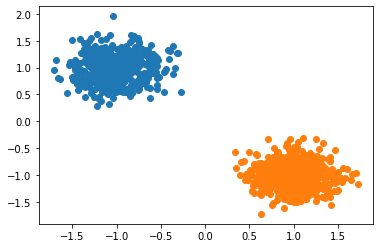

In [15]:
dist = tfp.distributions.Mixture(
    tfp.distributions.Categorical(probs=[.5, .5]),
    [
        tfp.distributions.MultivariateNormalDiag(loc=[-1., 1.], scale_diag=[.25, .25]),
        tfp.distributions.MultivariateNormalDiag(loc=[1., -1.], scale_diag=[.25, .25])
    ],
)
x = dist.sample(1000)
k = tf.constant(2, tf.int64)
dist_fn, _ = kmeans(x, k)
y = tfp.distributions.Categorical(probs=dist_fn(x)).mode()
x0 = x[y == 0]
x1 = x[y == 1]
plt.scatter(x0[:, 0], x0[:, 1])
plt.scatter(x1[:, 0], x1[:, 1])

## With Gradient Descent

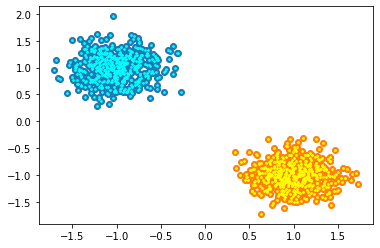

In [16]:
def logistic_regression_gradient_descent(x, y, min_norm=.2, max_norm=20.):
    gd = gradient_descent(1e-3)
    sx = tf.shape(x)
    sy = tf.shape(y)
    w = tfp.distributions.Normal(loc=tf.zeros([sx[-1], sy[-1]]), 
                                 scale=1e-3 * tf.ones([sx[-1], sy[-1]])).sample()
    b = tf.zeros([sy[-1]])
    norm = tf.constant((max_norm - min_norm) / 2)
    while norm > min_norm and norm < max_norm:
        with tf.GradientTape() as tape:
            tape.watch((w, b))
            ys = dense(w, b, activation=tf.nn.sigmoid)(x)
            loss = -tf.reduce_mean(
                y * tf.math.log(ys) + (1 - y) * tf.math.log(1 - ys))
        g = tape.gradient(loss, (w, b))
        norm = tf.linalg.global_norm(g)
        (w, b) = gd(g, (w, b))
    return w, b

plt.scatter(x0[:, 0], x0[:, 1])
plt.scatter(x1[:, 0], x1[:, 1])

fn = tf.function(logistic_regression_gradient_descent)
w, b = fn(x, tf.cast(y[:, None], tf.float32), min_norm=.2, max_norm=20.)
ys = tf.squeeze(dense(w, b, activation=tf.nn.sigmoid)(x))
x0s = x[ys <= 0.5]
x1s = x[ys > 0.5]
plt.scatter(x0s[:, 0], x0s[:, 1], s=3, c="cyan")
plt.scatter(x1s[:, 0], x1s[:, 1], s=3, c="yellow")

## With Newton's Method

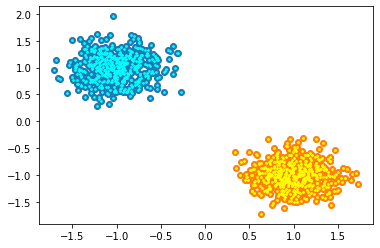

In [17]:
def logistic_regression_newtons_method(x, y, min_norm=.2, max_norm=20.):
    gd = newtons_method(1e-3)
    sx = tf.shape(x)
    sy = tf.shape(y)
    w = tfp.distributions.Normal(loc=tf.zeros([sx[-1], sy[-1]]), 
                                 scale=1e-3 * tf.ones([sx[-1], sy[-1]])).sample()
    b = tf.zeros([sy[-1]])
    norm = tf.constant((max_norm - min_norm) / 2)
    while norm > min_norm and norm < max_norm:
        with tf.GradientTape(persistent=True) as dtape:
            dtape.watch((w, b))
            with tf.GradientTape() as tape:
                tape.watch((w, b))
                ys = dense(w, b, activation=tf.nn.sigmoid)(x)
                loss = -tf.reduce_mean(
                    y * tf.math.log(ys) + (1 - y) * tf.math.log(1 - ys))
            (dw, db) = tape.gradient(loss, (w, b))
            norm = tf.linalg.global_norm((dw, db))
        (ddw, ddb) = tf.nest.map_structure(dtape.jacobian, (dw, db), (w, b))
        (w, b) = gd((dw, db), (ddw, ddb), (w, b))
        del dtape
    return w, b

plt.scatter(x0[:, 0], x0[:, 1])
plt.scatter(x1[:, 0], x1[:, 1])

fn = tf.function(logistic_regression_newtons_method)
w, b = fn(x, tf.cast(y[:, None], tf.float32), min_norm=.2, max_norm=20.)
ys = tf.squeeze(dense(w, b, activation=tf.nn.sigmoid)(x))
x0s = x[ys <= 0.5]
x1s = x[ys > 0.5]
plt.scatter(x0s[:, 0], x0s[:, 1], s=3, c="cyan")
plt.scatter(x1s[:, 0], x1s[:, 1], s=3, c="yellow")

## With Adam

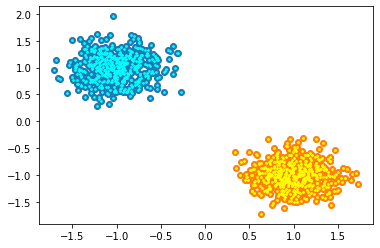

In [18]:
def logistic_regression_adam(x, y, min_norm=.2, max_norm=20.):
    gd = adam(1e-3, 0.9, 0.99, 1e-7)
    sx = tf.shape(x)
    sy = tf.shape(y)
    w = tfp.distributions.Normal(loc=tf.zeros([sx[-1], sy[-1]]), 
                                 scale=1e-3 * tf.ones([sx[-1], sy[-1]])).sample()
    b = tf.zeros([sy[-1]])
    ms = (tf.zeros_like(w), tf.zeros_like(b))
    vs = (tf.zeros_like(w), tf.zeros_like(b))
    t = tf.zeros([])
    norm = tf.constant((max_norm - min_norm) / 2)
    while norm > min_norm and norm < max_norm:
        with tf.GradientTape() as tape:
            tape.watch((w, b))
            ys = dense(w, b, activation=tf.nn.sigmoid)(x)
            loss = -tf.reduce_mean(
                y * tf.math.log(ys) + (1 - y) * tf.math.log(1 - ys))
        g = tape.gradient(loss, (w, b))
        norm = tf.linalg.global_norm(g)
        (w, b), ms, vs, t = gd(g, (w, b), ms, vs, t)
    return w, b

plt.scatter(x0[:, 0], x0[:, 1])
plt.scatter(x1[:, 0], x1[:, 1])

fn = tf.function(logistic_regression_adam)
w, b = fn(x, tf.cast(y[:, None], tf.float32), min_norm=.2, max_norm=20.)
ys = tf.squeeze(dense(w, b, activation=tf.nn.sigmoid)(x))
x0s = x[ys <= 0.5]
x1s = x[ys > 0.5]
plt.scatter(x0s[:, 0], x0s[:, 1], s=3, c="cyan")
plt.scatter(x1s[:, 0], x1s[:, 1], s=3, c="yellow")

# Deep learning (wip)

In [19]:
# TODO(x): 

# Hyperparameter Optimization (wip)

In [20]:
# TODO(x):